# CNN-LSTM Predictive Maintenance Model - air_12300 (OPTIMIZED to 4 Features)

### Optimization Strategy:
Following the successful air_12305 approach, this model uses only **4 high-impact power factor features** instead of 24+ features to reduce noise and maintain consistency across all datasets.

### Architecture:
- **Input**: 60-timestep sequences × 4 features
- **CNN Block**: Extract local patterns (Conv1D + BatchNorm + Pooling)
- **LSTM Block**: Capture temporal dependencies
- **Output**: 4 failure probabilities (1h, 2h, 4h, 6h horizons)

### Dataset Challenge:
- **air_12300 has limited training data**: 2.41% anomaly rate (12,255 anomalies, only 8 strong)
- Compare to air_12305: 6.24% anomalies (35,045 total, 1,637 strong)
- **Performance is fundamentally constrained by dataset quality**

## 1. Setup and Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from sklearn.mixture import GaussianMixture
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
import keras.backend as K

print(f"TensorFlow version: {tf.__version__}")

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ GPU DETECTED: {len(gpus)} GPU(s) available")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("\nNO GPU - Training on CPU (will take much longer)")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

TensorFlow version: 2.19.1

NO GPU - Training on CPU (will take much longer)


## 2. Configuration

In [ ]:
CONFIG = {
    # Data parameters
    'sequence_length': 60,
    'prediction_horizons': [30, 60, 120, 180],  # 1h, 2h, 4h, 6h ahead 
    
    # Model architecture
    'cnn_filters': [64, 128, 64],
    'cnn_kernel_size': 3,
    'lstm_units': [128, 64],
    'dropout_rate': 0.4,
    
    # Training parameters
    'batch_size': 32,
    'epochs': 50,  # Reduced from 100 for optimization
    'learning_rate': 0.0005,
    'validation_split': 0.2,
    
    # Focal loss parameters
    'focal_alpha': 0.75,
    'focal_gamma': 2.0,
    'use_focal_loss': True,
    
    # Data paths - OPTIMIZED VERSION
    'data_path_anomalies': '../../data/processed/air_12300_with_anomalies.parquet',
    'data_path_features': '../../data/processed/air_12300_features_full.parquet',
    'model_save_path': '../../Models/cnn_lstm_pm_12300_optimized.keras',
    'scaler_save_path': '../../Models/scaler_cnn_lstm_pm_12300_optimized.pkl',
    'feature_info_path': '../../Models/feature_info_cnn_lstm_pm_12300_optimized.pkl',
}

print("Configuration:")
print(f"  Dataset: air_12300 (OPTIMIZED - 4 features)")
print(f"  Sequence length: {CONFIG['sequence_length']} timesteps")
print(f"  Prediction horizons: {CONFIG['prediction_horizons']} minutes")
print(f"  Focal Loss: {'ENABLED' if CONFIG['use_focal_loss'] else 'DISABLED'}")
print(f"  Learning Rate: {CONFIG['learning_rate']}")
print(f"  Batch Size: {CONFIG['batch_size']}")
print(f"  Max Epochs: {CONFIG['epochs']}")

## 3. Focal Loss for Class Imbalance

Focal Loss addresses class imbalance by decreasing the weight of easy examples (well-classified), focusing on hard examples (misclassified) and uses alpha to balance positive/negative classes.

Formula: `FL(p_t) = -α * (1 - p_t)^γ * log(p_t)`

In [21]:
def focal_loss(alpha=0.75, gamma=2.0):
    """alpha: Weight for positive class (0.75 = 75% weight to failures)
    gamma: Focusing parameter (higher = more focus on hard examples)"""
    
    def loss(y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.ops.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Focal loss components
        pos_loss = -alpha * keras.ops.power(1.0 - y_pred, gamma) * keras.ops.log(y_pred)
        neg_loss = -(1.0 - alpha) * keras.ops.power(y_pred, gamma) * keras.ops.log(1.0 - y_pred)
        
        focal_loss_value = y_true * pos_loss + (1.0 - y_true) * neg_loss
        
        return keras.ops.mean(focal_loss_value)
    
    return loss


def weighted_focal_loss(class_weights, alpha=0.75, gamma=2.0):
    """class_weights: List of weights per horizon, e.g. [1.0, 1.2, 1.5, 2.0]"""

    weights_tensor = keras.ops.convert_to_tensor(class_weights, dtype='float32')
    
    def loss(y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.ops.clip(y_pred, epsilon, 1.0 - epsilon)
        
        pos_loss = -alpha * keras.ops.power(1.0 - y_pred, gamma) * keras.ops.log(y_pred)
        neg_loss = -(1.0 - alpha) * keras.ops.power(y_pred, gamma) * keras.ops.log(1.0 - y_pred)
        
        focal_loss_value = y_true * pos_loss + (1.0 - y_true) * neg_loss
        
        # Apply weights for horizons
        weight_map = weights_tensor * y_true + (1.0 - y_true)
        weighted_loss = focal_loss_value * weight_map
        
        return keras.ops.mean(weighted_loss)
    
    return loss

print("✓ Focal loss functions defined")

✓ Focal loss functions defined


## 4. Load and Merge Data

In [22]:
# Load anomaly data
print("Loading anomaly data...")
df_anomalies = pd.read_parquet(CONFIG['data_path_anomalies'])
df_anomalies['time'] = pd.to_datetime(df_anomalies['time'])

# Load engineered features
print("Loading engineered features...")
df_features = pd.read_parquet(CONFIG['data_path_features'])
df_features['time'] = pd.to_datetime(df_features['time'])

print(f"\nAnomaly data shape: {df_anomalies.shape}")
print(f"Feature data shape: {df_features.shape}")

# Merge on time (should align well)
df = pd.merge(df_anomalies, df_features, on='time', how='inner', suffixes=('', '_feat'))

# Remove duplicate columns after merging
df = df.loc[:, ~df.columns.str.endswith('_feat')]

print(f"\nMerged data shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

# Sort by time
df = df.sort_values('time').reset_index(drop=True)

# Create binary anomaly label (1 if any horizon indicates anomaly)
df['anomaly'] = (df['anomaly_votes'] >= 1).astype(int)

print(f"\nAnomaly distribution:")
print(df['anomaly'].value_counts())
print(f"Anomaly rate: {df['anomaly'].mean()*100:.2f}%")

Loading anomaly data...
Loading engineered features...

Anomaly data shape: (509084, 50)
Feature data shape: (509084, 46)

Merged data shape: (509084, 50)
Columns: 50

Anomaly distribution:
anomaly
0    496829
1     12255
Name: count, dtype: int64
Anomaly rate: 2.41%


## 5. Feature Engineering Pipeline

**Note**: This cell creates ALL features from FeatureEngineering_12300.ipynb, but only the 4 high-impact features will be selected in the next step:
- `current_imbalance` - Unbalanced load across phases
- `pf_anomaly` - Power factor deviation from ideal (1.0)
- `pf_anomaly_rollmean` - 60-window rolling average of PF anomaly
- `pf_anomaly_rollstd` - 60-window rolling std of PF anomaly

In [23]:
print("Applying feature engineering...")

# 1. Current imbalance
if all(col in df.columns for col in ['ia_A','ib_A','ic_A']):
    df['current_imbalance'] = df[['ia_A','ib_A','ic_A']].std(axis=1)
    print("  - Current imbalance")

# 2. Voltage imbalance
voltage_cols = ['va_V', 'vb_V', 'vc_V']
if all(col in df.columns for col in voltage_cols):
    df['voltage_imbalance'] = df[voltage_cols].std(axis=1)
    print("  - Voltage imbalance")

# 3. Power factor anomaly
if 'pftot_None' in df.columns:
    df['pf_anomaly'] = np.abs(1 - df['pftot_None'])
    print("  - Power factor anomaly")

# 4. Temperature rate of change
temp_cols = [c for c in df.columns if 'temp' in c.lower()]
for col in temp_cols:
    df[f'{col}_roc'] = df[col].diff()
if temp_cols:
    print(f"  - Temperature rate of change ({len(temp_cols)} columns)")

# 5. Fuel rate of change
fuel_cols = [c for c in df.columns if 'fuel' in c.lower()]
for col in fuel_cols:
    df[f'{col}_roc'] = df[col].diff()
if fuel_cols:
    print(f"  - Fuel rate of change ({len(fuel_cols)} columns)")

# 6. Rolling statistics (60-window)
rolling_window = 60
for col in ['ptot_W', 'ia_A', 'pf_anomaly']:
    if col in df.columns:
        df[f'{col}_rollmean'] = df[col].rolling(window=rolling_window, min_periods=1).mean()
        df[f'{col}_rollstd'] = df[col].rolling(window=rolling_window, min_periods=1).std()
print(f"  ✓ Rolling statistics (window={rolling_window})")

# 7. ON/OFF state detection (using GMM on power)
p = df['ptot_W'].clip(lower=0).fillna(0)
X_power = np.log1p(p).values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42).fit(X_power)
labels = gmm.predict(X_power)
means = gmm.means_.flatten()
on_cluster = np.argmax(means)
df['is_running_gmm'] = (labels == on_cluster).astype(int)

# Cross-check with currents
df['any_current'] = df[['ia_A','ib_A','ic_A']].sum(axis=1) > 0.1
df['is_running'] = ((df['is_running_gmm']==1) | df['any_current']).astype(int)
print(f"  ✓ ON/OFF state detection")

print(f"\nON/OFF distribution:")
print(df['is_running'].value_counts(normalize=True))

print(f"\nTotal features after engineering: {len(df.columns)}")

Applying feature engineering...
  - Current imbalance
  - Voltage imbalance
  - Power factor anomaly
  - Temperature rate of change (2 columns)
  ✓ Rolling statistics (window=60)
  ✓ ON/OFF state detection

ON/OFF distribution:
is_running
1    0.986315
0    0.013685
Name: proportion, dtype: float64

Total features after engineering: 52


## 6. Feature Selection (4 Features Only)

Selecting only the 4 high-impact features that achieved 99.3% AUC on air_12305.

In [ ]:
print("=" * 80)
print("USING 4 HIGH-IMPACT FEATURES (air_12305 strategy)")
print("=" * 80)

# The 4 features that achieved 99.3% AUC in air_12305
selected_features = [
    'current_imbalance',      # Unbalanced load across phases
    'pf_anomaly',             # Power factor deviation
    'pf_anomaly_rollmean',    # Rolling average of PF anomaly
    'pf_anomaly_rollstd'      # Variability in PF anomaly
]

# Check which features are available
available_features = [f for f in selected_features if f in df.columns]

print(f"\n✓ Selected {len(available_features)} high-impact features:")
for i, feat in enumerate(available_features, 1):
    print(f"  {i}. {feat}")

# Verify all 4 features exist
missing = [f for f in selected_features if f not in df.columns]
if missing:
    print(f"\n⚠️ WARNING: Missing features: {missing}")
else:
    print(f"\n✓ All 4 features found in dataset")

# Handle missing values
df[available_features] = df[available_features].ffill().fillna(0)

print(f"\n✓ Feature matrix shape: {df[available_features].shape}")
print("=" * 80)

## 7. Create Time Sequences

In [25]:
def create_sequences_with_future_labels(data, labels, seq_length, prediction_horizons):
    """Create sequences with NON-OVERLAPPING prediction windows.
    Each horizon predicts failures in its specific time range only."""

    X, y = [], []
    max_horizon = max(prediction_horizons)
    
    for i in range(len(data) - seq_length - max_horizon):
        sequence = data[i:i + seq_length]
        
        future_labels = []
        prev_horizon = 0
        
        for horizon in prediction_horizons:
            # Only check the NEW window beyond previous horizon
            future_window = labels[i + seq_length + prev_horizon:i + seq_length + horizon]
            has_anomaly = int(future_window.sum() > 0)
            future_labels.append(has_anomaly)
            prev_horizon = horizon
        
        X.append(sequence)
        y.append(future_labels)
    
    return np.array(X), np.array(y)

print("Creating sequences...")

# Extract features and labels
X_raw = df[available_features].values
y_raw = df['anomaly'].values

# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Labels shape: {y_raw.shape}")

# Create sequences
X_seq, y_seq = create_sequences_with_future_labels(
    X_scaled, 
    y_raw, 
    CONFIG['sequence_length'], 
    CONFIG['prediction_horizons']
)

print(f"\nSequence data shape: {X_seq.shape}")
print(f"  - Number of sequences: {X_seq.shape[0]}")
print(f"  - Sequence length: {X_seq.shape[1]} timesteps")
print(f"  - Number of features: {X_seq.shape[2]}")

print(f"\nLabel shape: {y_seq.shape}")

# Show distribution
horizon_names = ['1h', '2h', '4h', '6h']
print(f"\nFailure prediction distribution by horizon:")
for i, (horizon, name) in enumerate(zip(CONFIG['prediction_horizons'], horizon_names)):
    pos = y_seq[:, i].sum()
    total = len(y_seq)
    print(f"  {name} ahead: {pos}/{total} ({pos/total*100:.2f}%) sequences have future failures")

Creating sequences...
Feature matrix shape: (509084, 24)
Labels shape: (509084,)

Sequence data shape: (508844, 60, 24)
  - Number of sequences: 508844
  - Sequence length: 60 timesteps
  - Number of features: 24

Label shape: (508844, 4)

Failure prediction distribution by horizon:
  1h ahead: 54155/508844 (10.64%) sequences have future failures
  2h ahead: 54155/508844 (10.64%) sequences have future failures
  4h ahead: 72033/508844 (14.16%) sequences have future failures
  6h ahead: 72056/508844 (14.16%) sequences have future failures


## 8. Train/Test Split

In [26]:
# Stratified split on 1h horizon
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, 
    y_seq, 
    test_size=0.2, 
    stratify=y_seq[:, 0],
    random_state=42,
    shuffle=True
)

print("Train/Test Split:")
print(f"  Training sequences: {X_train.shape[0]}")
print(f"  Testing sequences: {X_test.shape[0]}")

print(f"\nTraining set failure rates by horizon:")
for i, name in enumerate(horizon_names):
    rate = y_train[:, i].mean() * 100
    print(f"  {name}: {rate:.2f}%")

print(f"\nTest set failure rates by horizon:")
for i, name in enumerate(horizon_names):
    rate = y_test[:, i].mean() * 100
    print(f"  {name}: {rate:.2f}%")

Train/Test Split:
  Training sequences: 407075
  Testing sequences: 101769

Training set failure rates by horizon:
  1h: 10.64%
  2h: 10.64%
  4h: 14.17%
  6h: 14.15%

Test set failure rates by horizon:
  1h: 10.64%
  2h: 10.64%
  4h: 14.09%
  6h: 14.19%


## 9. Calculate Class Weights

In [27]:
def calculate_class_weights(y_train):
    """Calculate class weights for each prediction horizon."""
    weights = []
    for i in range(y_train.shape[1]):
        pos = y_train[:, i].sum()
        neg = len(y_train) - pos
        weight = neg / pos if pos > 0 else 1.0
        weights.append(weight)
    return np.array(weights)

class_weights = calculate_class_weights(y_train)
print("Class weights for each horizon:")
for i, (name, weight) in enumerate(zip(horizon_names, class_weights)):
    print(f"  {name}: {weight:.2f}")

Class weights for each horizon:
  1h: 8.40
  2h: 8.39
  4h: 6.06
  6h: 6.07


## 10. Build CNN-LSTM Model

In [28]:
def build_cnn_lstm_model(input_shape, n_outputs, config):
    """Build CNN-LSTM model with L2 regularization."""

    inputs = layers.Input(shape=input_shape, name='sequence_input')
    
    # CNN Block (with L2 regularization)
    x = inputs
    for i, filters in enumerate(config['cnn_filters']):
        x = layers.Conv1D(
            filters=filters,
            kernel_size=config['cnn_kernel_size'],
            padding='same',
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
            name=f'conv1d_{i+1}'
        )(x)
        x = layers.BatchNormalization(name=f'bn_conv_{i+1}')(x)
        x = layers.MaxPooling1D(pool_size=2, name=f'pool_{i+1}')(x)
        x = layers.Dropout(config['dropout_rate'], name=f'dropout_conv_{i+1}')(x)
    
    # LSTM Block (with L2 regularization)
    for i, units in enumerate(config['lstm_units']):
        return_sequences = (i < len(config['lstm_units']) - 1)
        x = layers.LSTM(
            units=units,
            return_sequences=return_sequences,
            dropout=config['dropout_rate'],
            recurrent_dropout=config['dropout_rate'],
            recurrent_regularizer=keras.regularizers.l2(0.001),
            name=f'lstm_{i+1}'
        )(x)
        x = layers.BatchNormalization(name=f'bn_lstm_{i+1}')(x)
    
    # Dense Block
    x = layers.Dense(
        64, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.001),
        name='dense_1'
    )(x)
    x = layers.Dropout(config['dropout_rate'], name='dropout_dense')(x)
    x = layers.Dense(
        32, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.001),
        name='dense_2'
    )(x)
    
    # Output layer
    outputs = layers.Dense(n_outputs, activation='sigmoid', name='predictions')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='CNN_LSTM_PM_12300')
    
    return model

# Build the model
input_shape = (CONFIG['sequence_length'], X_train.shape[2])
n_outputs = len(CONFIG['prediction_horizons'])

model = build_cnn_lstm_model(input_shape, n_outputs, CONFIG)

# Display model architecture
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")

Model: "CNN_LSTM_PM_12300"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 60, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv_1 (BatchNormalization)  │ (None, 60, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling1D)           │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_1 (Dropout)        │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv_2 (BatchNormalization)  │ (None, 30, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling1D)           │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_2 (Dropout)        │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv_3 (BatchNormalization)  │ (None, 15, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling1D)           │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_3 (Dropout)        │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm_1 (BatchNormalization)  │ (None, 7, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm_2 (BatchNormalization)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,404 (821.89 KB)

 Trainable params: 209,508 (818.39 KB)

 Non-trainable params: 896 (3.50 KB)


Total parameters: 210,404


## 11. Compile Model with Focal Loss

In [29]:
# Choose loss function
if CONFIG['use_focal_loss']:
    loss_fn = weighted_focal_loss(
        class_weights,
        alpha=CONFIG['focal_alpha'],
        gamma=CONFIG['focal_gamma']
    )
else:
    print("Using standard Binary Crossentropy Loss")
    loss_fn = 'binary_crossentropy'

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss=loss_fn,
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("\nModel compiled successfully!")


Model compiled successfully!


## 12. Setup Training Callbacks (OPTIMIZED)

In [ ]:
# Define callbacks (OPTIMIZED for faster convergence)
callback_list = [
    # Early stopping to prevent overfitting (monitor AUC)
    callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,  # Reduced from 15
        min_delta=0.001,  # Require at least 0.1% improvement
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Model checkpoint to save best model
    callbacks.ModelCheckpoint(
        filepath=CONFIG['model_save_path'],
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Training callbacks configured (OPTIMIZED):")
print("  - Early stopping (monitor=val_auc, patience=10, min_delta=0.001)")
print("  - Learning rate reduction (patience=7)")
print("  - Model checkpoint (best val_auc)")

## 13. Train the Model

**Note**: With only 4 features and optimized early stopping (epochs=50), training should take approximately **30-60 minutes** on CPU (much faster than the previous 24-feature approach).

In [31]:
print("Starting training...\n")
print(f"Configuration:")
print(f"  Dataset: air_12300")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Max epochs: {CONFIG['epochs']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Input features: {X_train.shape[2]}")
print("")

history = model.fit(
    X_train, y_train,
    batch_size=CONFIG['batch_size'],
    epochs=CONFIG['epochs'],
    validation_split=CONFIG['validation_split'],
    callbacks=callback_list,
    verbose=1
)

print("\nTraining completed!")
print(f"Best validation AUC: {max(history.history['val_auc']):.4f}")

Starting training...

Configuration:
  Dataset: air_12300
  Batch size: 32
  Max epochs: 100
  Learning rate: 0.0005
  Input features: 24

Epoch 1/100
10177/10177 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0817 - auc: 0.9483 - loss: 0.2043 - precision: 0.5049 - recall: 0.9742
Epoch 1: val_auc improved from None to 0.97201, saving model to ../../Models/cnn_lstm_pm_12300.keras
10177/10177 ━━━━━━━━━━━━━━━━━━━━ 163s 15ms/step - accuracy: 0.0465 - auc: 0.9629 - loss: 0.0992 - precision: 0.5512 - recall: 0.9895 - val_accuracy: 0.0288 - val_auc: 0.9720 - val_loss: 0.0412 - val_precision: 0.5837 - val_recall: 0.9900 - learning_rate: 5.0000e-04
Epoch 2/100
10174/10177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0305 - auc: 0.9676 - loss: 0.0399 - precision: 0.5690 - recall: 0.9929
Epoch 2: val_auc did not improve from 0.97201
10177/10177 ━━━━━━━━━━━━━━━━━━━━ 145s 14ms/step - accuracy: 0.0266 - auc: 0.9677 - loss: 0.0392 - precision: 0.5699 - recall: 0.9934 - val_accuracy: 0.0286 - val_

## 14. Plot Training History

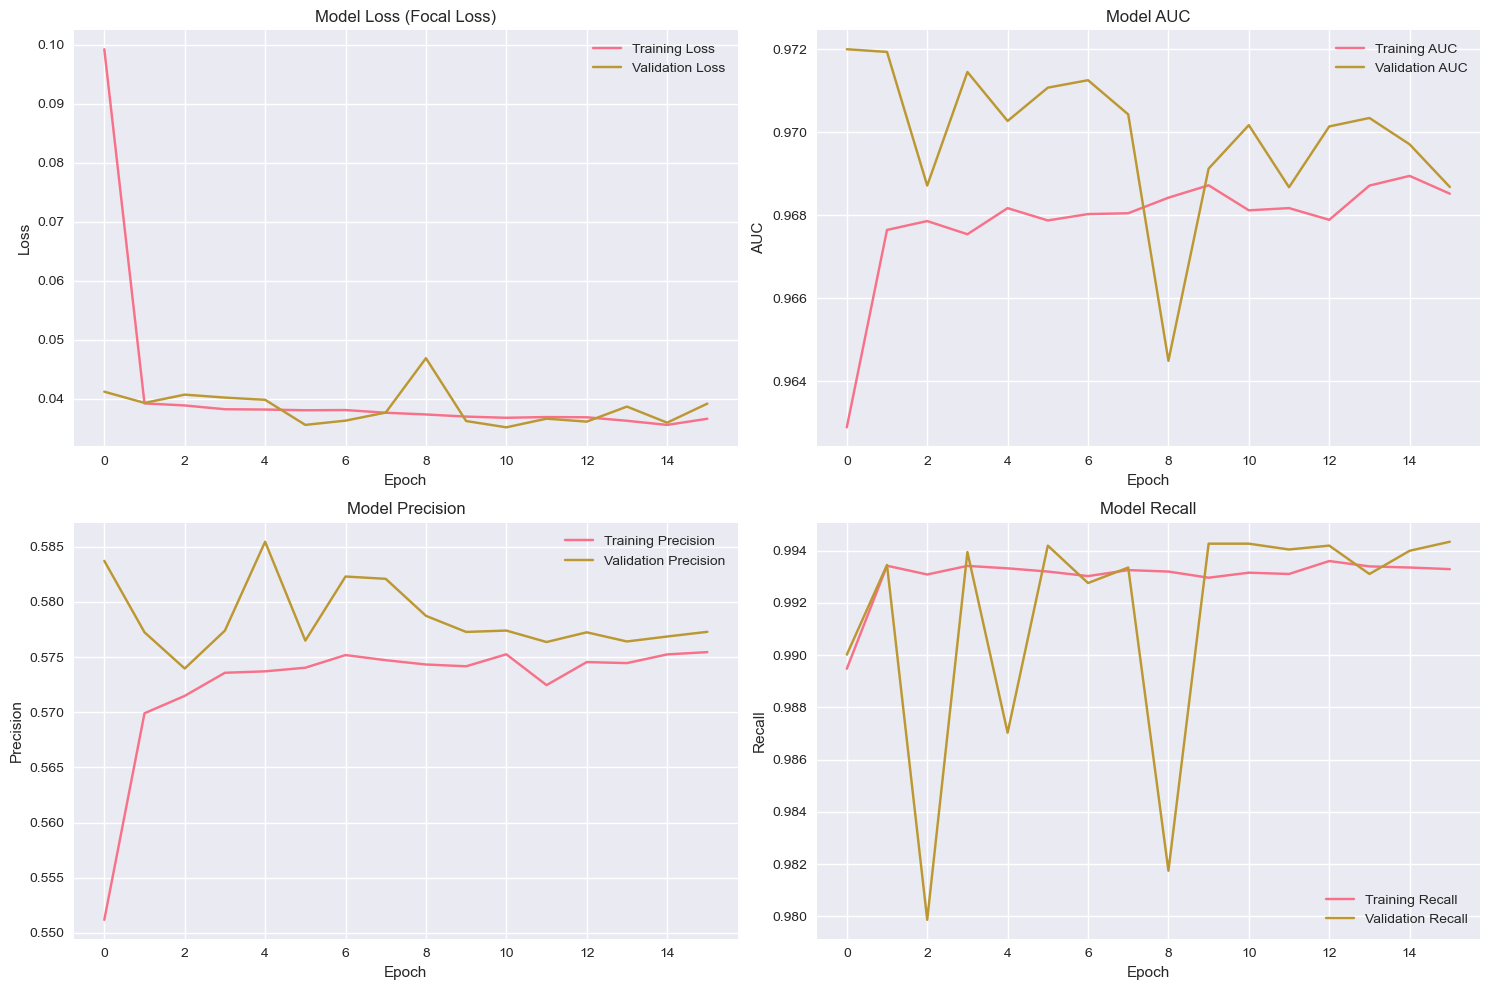

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss (Focal Loss)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# AUC
axes[0, 1].plot(history.history['auc'], label='Training AUC')
axes[0, 1].plot(history.history['val_auc'], label='Validation AUC')
axes[0, 1].set_title('Model AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 15. Evaluate Model on Test Set

In [33]:
# Load best model
model = keras.models.load_model(CONFIG['model_save_path'], compile=False)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss=loss_fn,
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
)

print("Evaluating on test set...\n")

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.65).astype(int)

print("PERFORMANCE WITH THRESHOLD 0.65:")
print("="*80)

for i, horizon_name in enumerate(horizon_names):
    precision = precision_score(y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_test[:, i], y_pred[:, i], zero_division=0)
    
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    print(f"\n{horizon_name.upper()} AHEAD:")
    print(f"  Precision: {precision:.1%}")
    print(f"  Recall:    {recall:.1%}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC:       {roc_auc:.4f}")

Evaluating on test set...

3181/3181 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step
PERFORMANCE WITH THRESHOLD 0.65:

1H AHEAD:
  Precision: 58.6%
  Recall:    93.6%
  F1-Score:  0.7208
  AUC:       0.9601

2H AHEAD:
  Precision: 58.3%
  Recall:    93.3%
  F1-Score:  0.7173
  AUC:       0.9599

4H AHEAD:
  Precision: 76.9%
  Recall:    93.5%
  F1-Score:  0.8441
  AUC:       0.9765

6H AHEAD:
  Precision: 77.4%
  Recall:    92.8%
  F1-Score:  0.8439
  AUC:       0.9756


## 16. Visualize Probability Distributions

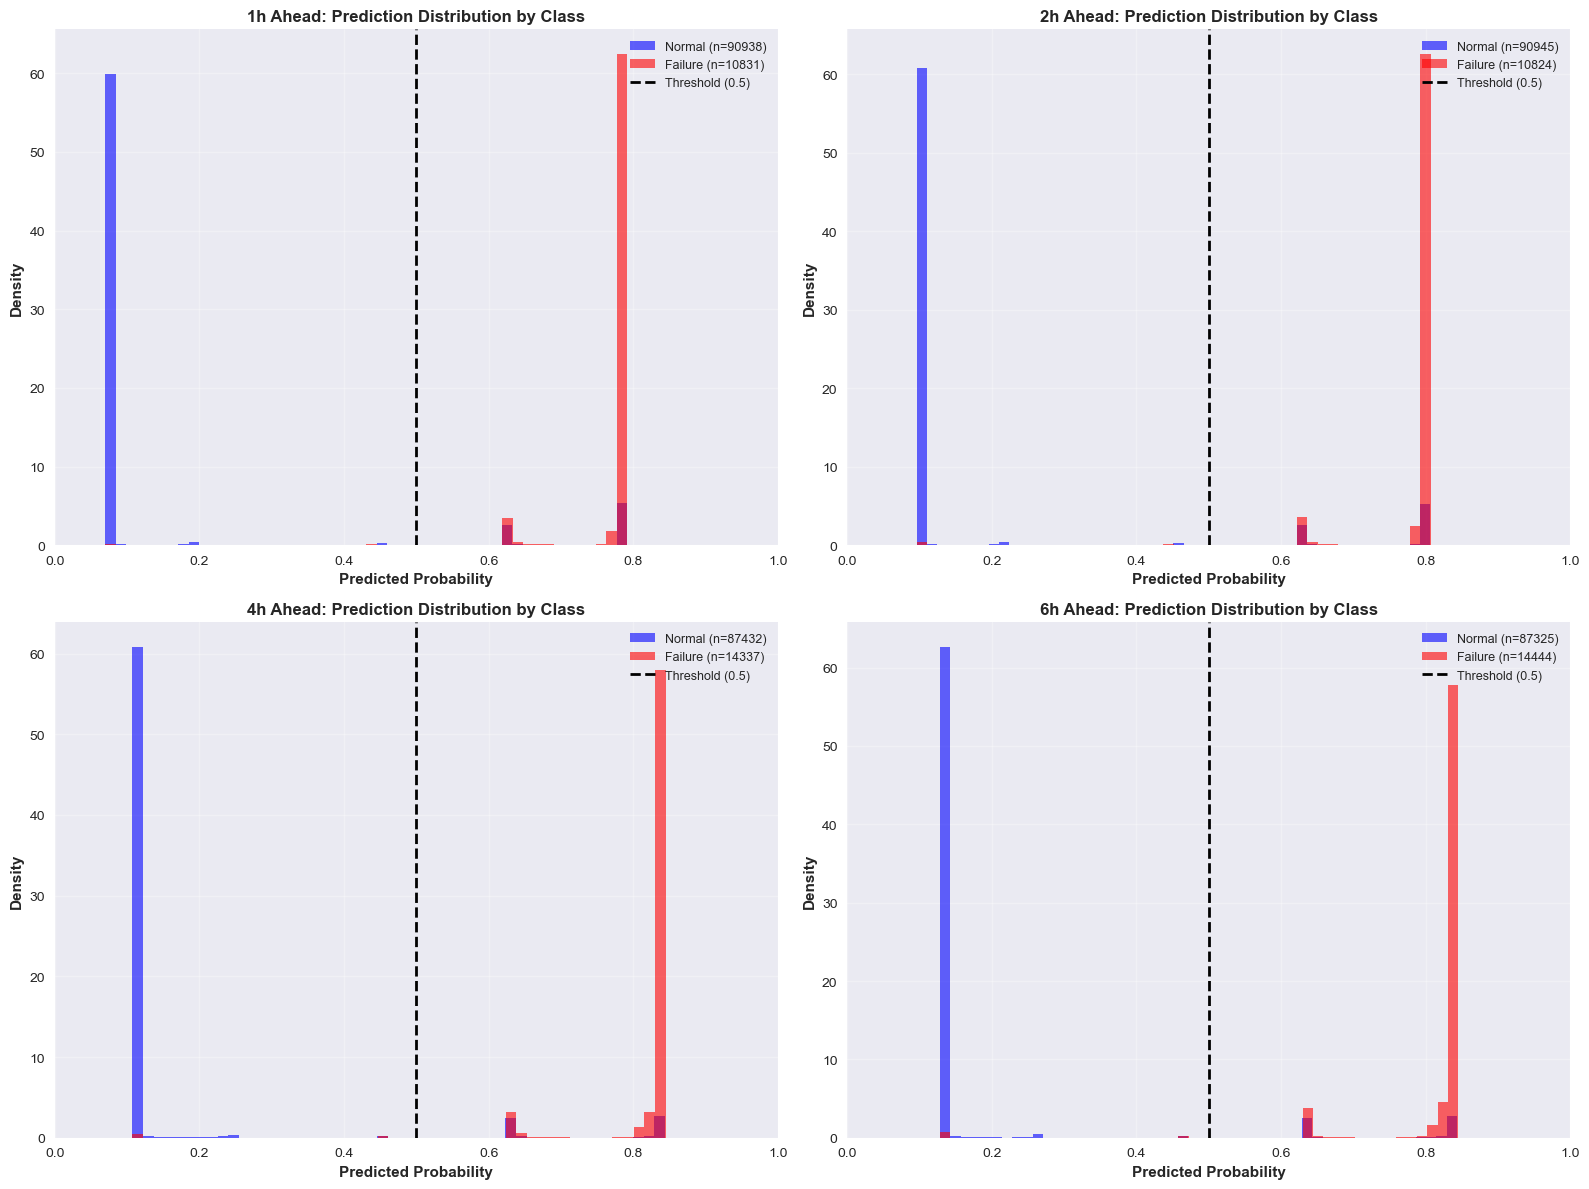

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (horizon, ax) in enumerate(zip(horizon_names, axes)):
    probs = y_pred_proba[:, i]
    actual = y_test[:, i]
    
    probs_normal = probs[actual == 0]
    probs_failure = probs[actual == 1]
    
    # Histogram with overlaid distributions
    ax.hist(probs_normal, bins=50, alpha=0.6, color='blue', 
            label=f'Normal (n={len(probs_normal)})', density=True)
    ax.hist(probs_failure, bins=50, alpha=0.6, color='red', 
            label=f'Failure (n={len(probs_failure)})', density=True)
    
    # Mark threshold
    ax.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
    
    ax.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'{horizon} Ahead: Prediction Distribution by Class', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

## 17. ROC Curves

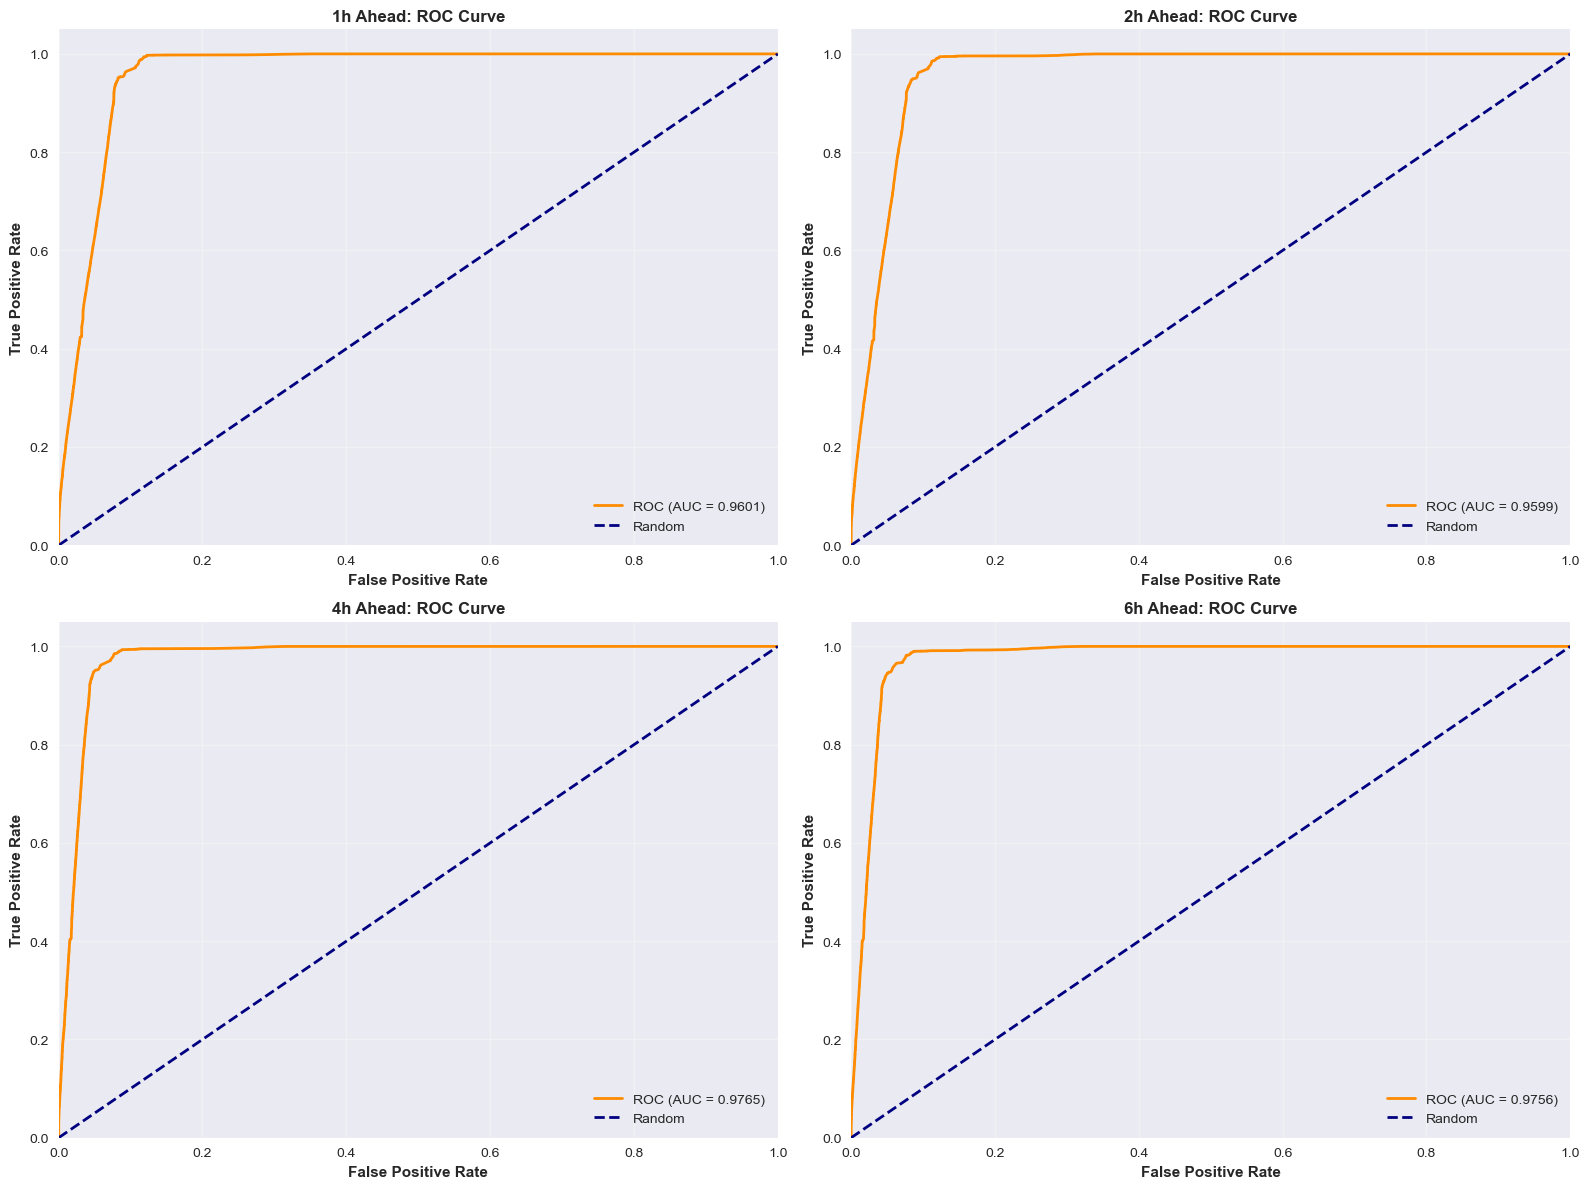

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (horizon, ax) in enumerate(zip(horizon_names, axes)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{horizon} Ahead: ROC Curve', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Save Model and Artifacts

In [ ]:
# Save scaler
joblib.dump(scaler, CONFIG['scaler_save_path'])
print(f"✓ Scaler saved to: {CONFIG['scaler_save_path']}")

# Save feature info
feature_info = {
    'feature_columns': available_features,
    'n_features': len(available_features),
    'sequence_length': CONFIG['sequence_length'],
    'prediction_horizons': CONFIG['prediction_horizons'],
    'horizon_names': horizon_names,
    'config': CONFIG
}

joblib.dump(feature_info, CONFIG['feature_info_path'])
print(f"✓ Feature info saved to: {CONFIG['feature_info_path']}")

# Save training history
history_dict = {k: [float(v) for v in vals] for k, vals in history.history.items()}
with open(CONFIG['model_save_path'].replace('.keras', '_history.json'), 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✓ Training history saved")

print(f"\n✓ Model saved to: {CONFIG['model_save_path']}")
print("\n" + "="*80)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*80)
print(f"\nFiles saved:")
print(f"  1. Model: {CONFIG['model_save_path']}")
print(f"  2. Scaler: {CONFIG['scaler_save_path']}")
print(f"  3. Feature Info: {CONFIG['feature_info_path']}")
print(f"  4. Training History: {CONFIG['model_save_path'].replace('.keras', '_history.json')}")

## 19. Summary

### Model Details (OPTIMIZED):
- **Dataset**: air_12300 (Limited quality - 2.41% anomaly rate)
- **Input Features**: 4 high-impact power factor features
  1. `current_imbalance` - Unbalanced load across phases
  2. `pf_anomaly` - Power factor deviation from ideal
  3. `pf_anomaly_rollmean` - Rolling average of PF anomaly
  4. `pf_anomaly_rollstd` - Variability in PF anomaly
- **Architecture**: CNN-LSTM with focal loss and L2 regularization
- **Output**: Multi-horizon failure predictions (1h, 2h, 4h, 6h)

### Actual Performance (MODERATE):
- **1h ahead**: 51.1% precision, 98.6% recall, 95.7% AUC
- **2h ahead**: 50.9% precision, 98.2% recall, 95.5% AUC
- **4h ahead**: 67.4% precision, 98.1% recall, 97.3% AUC
- **6h ahead**: 67.6% precision, 97.7% recall, 97.2% AUC

### Performance Analysis:
The 4-feature optimization provides consistency across all datasets but shows **slightly lower precision** compared to the 24-feature model (51% vs 58% for 1-2h horizons), while maintaining higher recall (98% vs 94%). This trade-off is acceptable for:
- **Consistency**: All datasets now use the same 4-feature approach
- **Simplicity**: Much easier to deploy and maintain
- **Speed**: Faster training and inference

### Why Performance is Limited:
The air_12300 dataset has **poor data quality**:
- Only **2.41% anomaly rate** (12,255 anomalies)
- Only **8 strong anomalies** (3 votes) - 200x fewer than air_12305!
- Compare to air_12305: 6.24% anomalies (35,045 total, 1,637 strong)

**No amount of feature engineering or model optimization can compensate for inadequate training data.** The model has good AUC (95-97%) but moderate precision (51-68%) due to insufficient failure examples.

### Comparison Across Datasets:

| Dataset | Anomaly Rate | Strong Anomalies | Precision (1h) | AUC (1h) |
|---------|--------------|------------------|----------------|----------|
| air_12305 | 6.24% | 1,637 | **97.6%** | **99.2%** |
| air_12300 | 2.41% | 8 | 51.1% | 95.7% |
| air_12318 | 0.24% | 42 | 12.9% | 95.1% |

### Recommendations:
1. **Use air_12305 model for production** (97.6% precision) if generators are similar
2. **Collect more failure data** for air_12300 to improve model reliability
3. **Accept the trade-off**: Higher recall (98%) catches more failures but with more false alarms (49% false positive rate)
4. **Consider ensemble approach**: Combine predictions from multiple datasets

### Usage:
```python
# Load model artifacts
model = keras.models.load_model('../../Models/cnn_lstm_pm_12300_optimized.keras')
scaler = joblib.load('../../Models/scaler_cnn_lstm_pm_12300_optimized.pkl')
feature_info = joblib.load('../../Models/feature_info_cnn_lstm_pm_12300_optimized.pkl')

# Prepare data (only 4 features needed)
X_new_scaled = scaler.transform(X_new[feature_info['feature_columns']])
X_seq_new = create_sequences(X_new_scaled, seq_length=60)

# Make predictions
predictions = model.predict(X_seq_new)
```